# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [159]:
# Run some setup code for this notebook.
import random
import os
import numpy as np
from fduml.utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [160]:
# Load the raw CIFAR-10 data.
# dir = os.path.dirname(os.path.realpath(__file__))
# cifar10_dir = os.path.join(dir, 'datasets/cifar')

cifar10_dir = 'datasets/cifar'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   print('Everything is ok.')
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


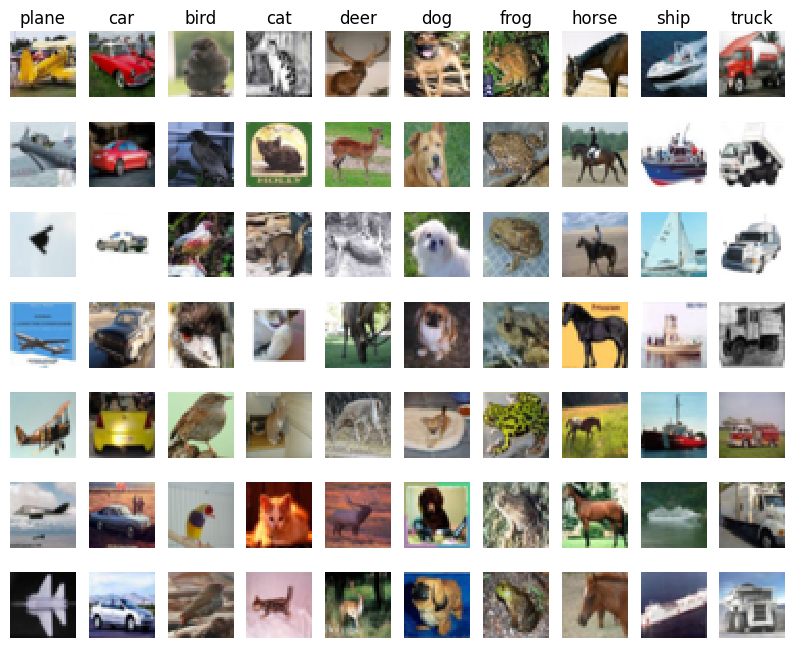

In [161]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        # plt_idx starts from 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### np.flatnonzero

The `np.flatnonzero` function returns the indices of the non-zero elements in a flattened version of the input array. It’s particularly useful when you need the positions of non-zero values from a multi-dimensional array without considering its original shape.

#### np.random.choice

The `np.random.choice` function is used to randomly select elements from a given 1-D array. You can specify various options, such as whether the selection is done with or without replacement, the probability of each element being chosen, and the number of elements to select.

- replace: If `True`, the same element can be chosen more than once (sampling with replacement). If `False`, each element can only be chosen once (sampling without replacement).

In [162]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)  # [49000, 49999]
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [163]:
X_train.shape

(49000, 32, 32, 3)

In [164]:
# Preprocessing: reshape the image data into rows
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_dev = X_dev.reshape(X_dev.shape[0], -1)


# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]
(3072,)


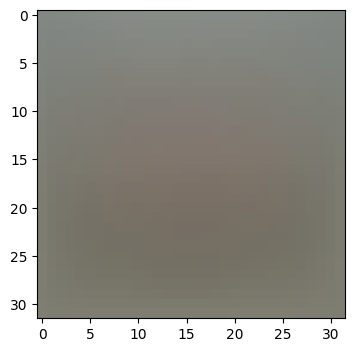

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [165]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
print(mean_image.shape)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# y = x W + b can be written as
# y = [x 1][W]
#          [b]
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `Exercise3/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [166]:
# Evaluate the naive implementation of the loss we provided for you:
from fduml.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e-6)
print(f'loss: {loss}\ngrad: {grad}')

loss: 9.683571622661248
grad: [[-21.8583778    2.70926947   3.82963474 ...  -7.22248522 -10.38794449
  -39.22064816]
 [-32.32975347   3.27641102   4.33520551 ...  -3.80379918 -22.49838367
  -48.46546122]
 [-53.51250384   1.80744277  18.16672139 ...  -0.14342498 -48.19825959
  -60.45208653]
 ...
 [-24.90725192  -6.86177861   2.74111069 ... -11.82071249  32.7608702
  -22.48904327]
 [-42.07964114 -15.82074343  11.00562829 ...   4.34711086  10.85189714
  -25.02203428]
 [ -0.096        0.132        0.066      ...  -0.208       -0.24
   -0.08      ]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

## Only update `dW` when margin > 0

In [167]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from fduml.utils import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 21.721694 analytic: 21.721694, relative error: 1.504748e-11
numerical: 4.335719 analytic: 4.335719, relative error: 1.923935e-11
numerical: 1.301667 analytic: 1.301667, relative error: 2.002911e-10
numerical: -16.244389 analytic: -16.144238, relative error: 3.092144e-03
numerical: -8.020285 analytic: -8.020285, relative error: 2.190777e-11
numerical: -5.529244 analytic: -5.529244, relative error: 6.655662e-11
numerical: 1.972231 analytic: 1.962155, relative error: 2.560923e-03
numerical: -19.258818 analytic: -19.342522, relative error: 2.168441e-03
numerical: -37.876557 analytic: -37.863713, relative error: 1.695818e-04
numerical: 22.158209 analytic: 22.098864, relative error: 1.340925e-03
numerical: -6.340372 analytic: -6.347711, relative error: 5.784624e-04
numerical: 5.258492 analytic: 5.282672, relative error: 2.293873e-03
numerical: -28.532537 analytic: -28.532537, relative error: 1.421644e-12
numerical: -25.838868 analytic: -25.899210, relative error: 1.166293e-03
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ SVM Loss Function 有不可微点，这个点的梯度不能用公式近似，因为不同方向梯度不同。Margin 越大，离那条分界线的点就越多，因为margin越大被错误分类的概率越大，而分界线就是不可微点聚集的地方。（有点抽象）


对于图像 $i$，$j$ 从$0$遍历到 $C - 1$，

$$
margin[j] = \begin{cases} score[j] - score[y_i] + 1, & j \neq y_i \\ 0, & j = y_i \end{cases}
$$

由于只有大于0的margin才会被计算在loss和gradient中，所以需要首先计算出所有图像i的每一个j对应的margin，存放在矩阵`tmp`中，然后使用 numpy 的boolean index来筛选大于0的元素做求和。

#### Loss

$$
R_{i}(tmp) = [m[0], m[1], \ldots m[C-1]]\\
= s_{i} - s_{i}[y_i] \cdot 1^{T}_{C} + 1^{T}_{C} - e^{T}_{y_i}
$$

$$
tmp = XW - XW[:, y] 1^{T}_{C} + 1_{N \times C} - I_{C}[y, :]
$$

$$
L = \sum tmp[tmp > 0]
$$

#### Gradient

gradient 其实是 tmp中大于0的元素对W的梯度（与W的维度相同）的和。如果直接在tmp上求梯度，得到的dW会偏大，因为额外计算了tmp小于0的元素的梯度。所以，在矩阵乘法的时候，要根据tmp的正负调整倍增的次数，把某些项置零。具体如下

**如果不考虑 tmp > 0**：

$$
dW =\frac{ X^{T} 1_{N \times C} - C \cdot X^{T} I_{C}[y, :]}{N} + 2 \cdot reg \cdot W
$$

**如果考虑 tmp > 0**:

第一项把tmp < 0的地方设为0，其他保留。
$$
X^{T} 1_{N \times C} \to X^{T} 1_{N \times C}[tmp > 0]
$$

第二项本质：本来是 - C 乘以什么，即每一个margin都要减，但是现在有些margin < 0不用减，需要定义一个系数矩阵Multi，它是一个单位阵（本来的系数C也可以看作 $C \cdot I$）。Multi代表了tmp每一行有多少个大于0的margin
$$
C \cdot X^{T} I_{C}[y, :] \to (M X)^{T}I_{C}[y, :]
$$


In [168]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from fduml.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.683572e+00 computed in 0.277144s
Vectorized loss: 9.683572e+00 computed in 0.006166s
difference: -0.000000


In [169]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.273630s
Vectorized loss and gradient: computed in 0.011850s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [170]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from fduml.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 791.457126
iteration 100 / 1500: loss 289.283457
iteration 200 / 1500: loss 108.898476
iteration 300 / 1500: loss 43.170497
iteration 400 / 1500: loss 18.865647
iteration 500 / 1500: loss 10.367904
iteration 600 / 1500: loss 6.849332
iteration 700 / 1500: loss 6.365740
iteration 800 / 1500: loss 5.762581
iteration 900 / 1500: loss 5.516792
iteration 1000 / 1500: loss 5.291453
iteration 1100 / 1500: loss 5.172848
iteration 1200 / 1500: loss 5.646848
iteration 1300 / 1500: loss 5.343393
iteration 1400 / 1500: loss 5.122920
That took 7.558873s


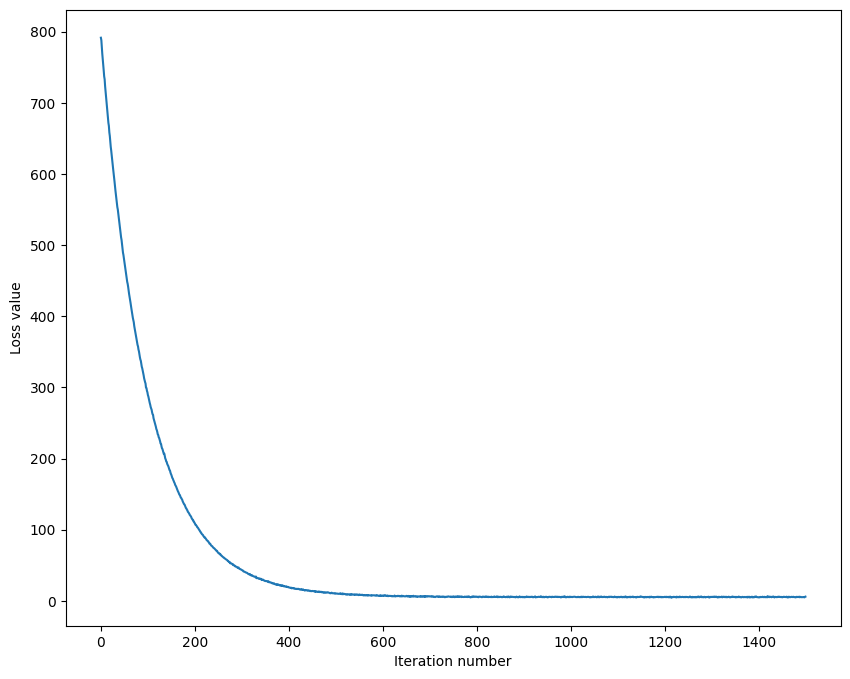

In [171]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [172]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370408
validation accuracy: 0.382000


In [173]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [3.9e-7, 4.2e-7, 4.5e-7, 5.1e-7, 5.4e-7, 5.7e-7, 6e-7, 6.3e-7]
regularization_strengths = [7.9e-5, 8.2e-5, 8.5e-5, 8.8e-5, 9.1e-5, 9.5e-5, 9.8e-5, 1.1e-4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=3000, verbose=False)
        
        y_train_red = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.900000e-07 reg 7.900000e-05 train accuracy: 0.370408 val accuracy: 0.365000
lr 3.900000e-07 reg 8.200000e-05 train accuracy: 0.370408 val accuracy: 0.358000
lr 3.900000e-07 reg 8.500000e-05 train accuracy: 0.370408 val accuracy: 0.339000
lr 3.900000e-07 reg 8.800000e-05 train accuracy: 0.370408 val accuracy: 0.358000
lr 3.900000e-07 reg 9.100000e-05 train accuracy: 0.370408 val accuracy: 0.344000
lr 3.900000e-07 reg 9.500000e-05 train accuracy: 0.370408 val accuracy: 0.355000
lr 3.900000e-07 reg 9.800000e-05 train accuracy: 0.370408 val accuracy: 0.356000
lr 3.900000e-07 reg 1.100000e-04 train accuracy: 0.370408 val accuracy: 0.356000
lr 4.200000e-07 reg 7.900000e-05 train accuracy: 0.370408 val accuracy: 0.366000
lr 4.200000e-07 reg 8.200000e-05 train accuracy: 0.370408 val accuracy: 0.358000
lr 4.200000e-07 reg 8.500000e-05 train accuracy: 0.370408 val accuracy: 0.349000
lr 4.200000e-07 reg 8.800000e-05 train accuracy: 0.370408 val accuracy: 0.356000
lr 4.200000e-07 reg 9.100000

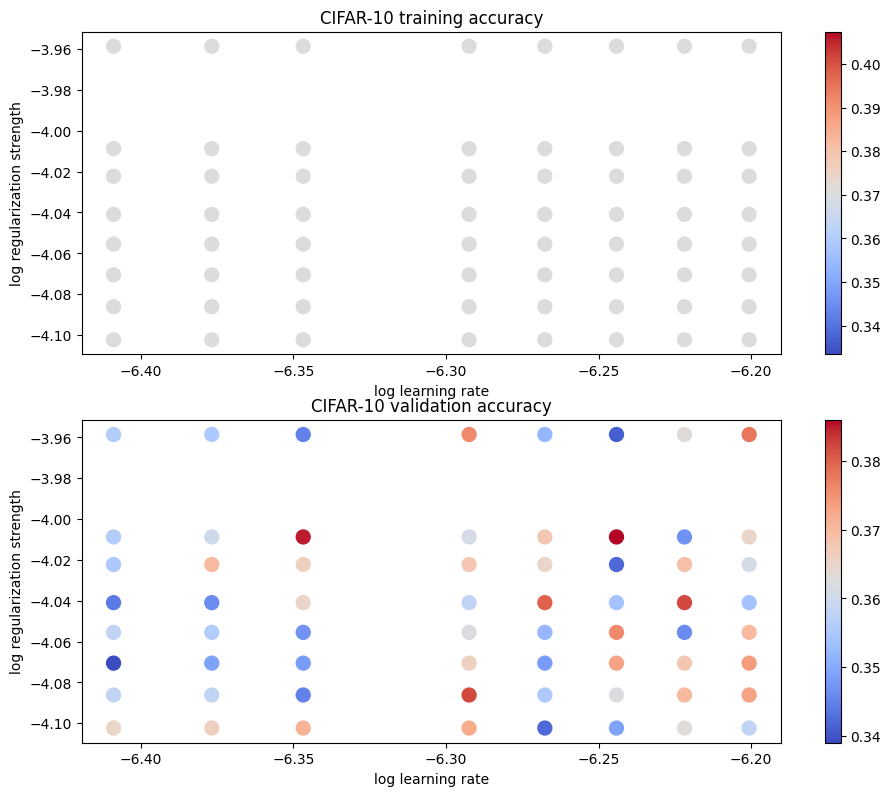

In [175]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [176]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.345000


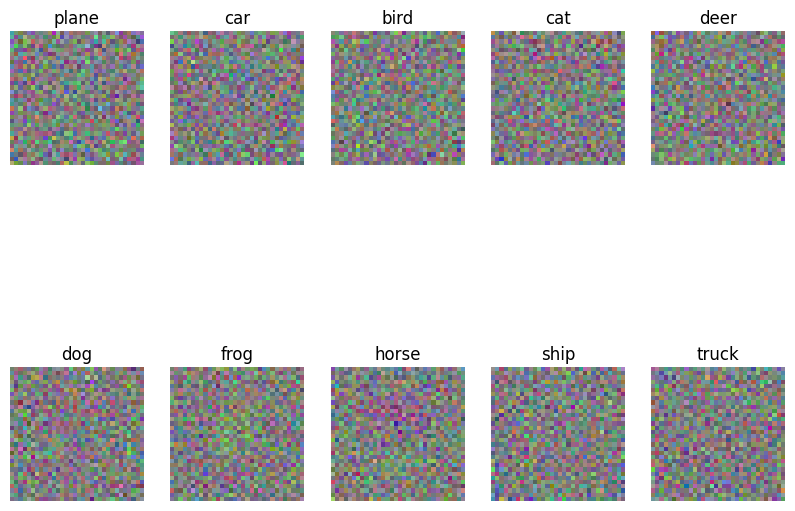

In [177]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ 深色的地方看起来像物体的轮廓和关键点。因为对应列的weight要刻画重要的像素点，给予他们更多的权重。
